In [2]:
pip install pyspellchecker

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Library Files

In [23]:
import pandas
import numpy
import nltk
import string
from spellchecker import SpellChecker
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import average_precision_score, roc_curve, roc_auc_score, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##  Data Preparation

In [0]:
sentiment140_df = pandas.read_csv("/content/drive/My Drive/AWT/Dataset/Sentiment140/train.csv", 
                 header=None, 
                 names=['target', 'ids', 'date', 'flag', 'user', 'text'],
                 encoding='latin-1')

In [0]:
sentiment140_df["target_bool"] = numpy.where(sentiment140_df["target"]>=2, 1,0)

In [8]:
sentiment140_df[:5]

,target,ids,date,flag,user,text,target_bool
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


##Data Cleaning

In [0]:
sentiment140_df["text_lower"] = sentiment140_df["text"].str.lower()
#sentiment140_df["text_lower"]

In [0]:
sentiment140_df["text_punctuation"] = sentiment140_df["text_lower"].str.replace("[@.,-;:&?]", " ")
#sentiment140_df["text_punctuation"]

In [0]:
def string_words(sentence , words):
    sent = sentence
    remove_list = words
    translator = str.maketrans("[@.,-;:&?]", ' '*len("[@.,-;:&?]"))   # mapping of punctuation 
    word_list = (sent.translate(translator)).split()
    m = ' '.join([i for i in word_list if i not in remove_list])
    return m
  

In [0]:
stops = stopwords.words("english")

sentiment140_df["text_stopwords"] = sentiment140_df["text_punctuation"].apply(lambda sentence : string_words(sentence, stops))
#sentiment140_df["text_stopwords"]

##TFID Vectorization

In [17]:
#parameters
max_df = 0.3
min_df = 0.003 
toxicity_threshold = 0.2
n_gram = (1, 3)

#processing
texts = sentiment140_df[sentiment140_df['target'] > toxicity_threshold ]['text_stopwords']
tfidf = TfidfVectorizer(min_df= numpy.int(min_df * texts.shape[0]), max_df=max_df, ngram_range=n_gram)
features = tfidf.fit_transform(texts)
vectorizer = pandas.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names()
)
print( "column names are " + str(vectorizer.columns.values), " Number of column is " + str (vectorizer.columns.shape))

column names are ['actually' 'add' 'afternoon' 'ah' 'album' 'almost' 'already' 'also'
 'always' 'amazing' 'amp' 'another' 'anyone' 'anything' 'around' 'away'
 'awesome' 'aww' 'baby' 'back' 'bad' 'beach' 'beautiful' 'bed' 'believe'
 'best' 'better' 'big' 'birthday' 'bit' 'bit ly' 'blip' 'blip fm' 'blog'
 'book' 'bought' 'boy' 'breakfast' 'btw' 'busy' 'buy' 'call' 'came' 'can'
 'can wait' 'cant' 'cant wait' 'car' 'cause' 'check' 'coffee' 'com' 'come'
 'coming' 'congrats' 'cool' 'could' 'course' 'crazy' 'cute' 'day' 'days'
 'definitely' 'dinner' 'done' 'dont' 'early' 'eat' 'eating' 'end' 'enjoy'
 'enjoying' 'enough' 'even' 'ever' 'every' 'everyone' 'everything'
 'excited' 'facebook' 'family' 'fan' 'far' 'favorite' 'feel' 'feeling'
 'finally' 'find' 'fine' 'finished' 'first' 'fm' 'follow' 'followers'
 'followfriday' 'following' 'food' 'forward' 'found' 'free' 'friday'
 'friend' 'friends' 'full' 'fun' 'funny' 'game' 'get' 'getting'
 'getting ready' 'girl' 'girls' 'give' 'glad' 'go' 'god' 'g

## Data Splitting

In [0]:
X = tfidf.transform(sentiment140_df["text_stopwords"])
y=  sentiment140_df["target_bool"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state =42)

## Model Implementation

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.769


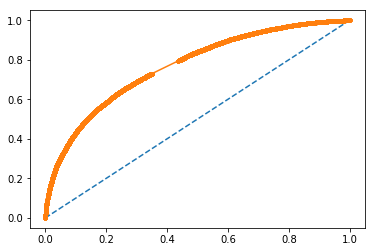

'              precision    recall  f1-score   support\n\n           0       0.68      0.74      0.71     39999\n           1       0.71      0.66      0.68     40001\n\n    accuracy                           0.70     80000\n   macro avg       0.70      0.70      0.70     80000\nweighted avg       0.70      0.70      0.70     80000\n'

In [22]:
model_1 = LogisticRegression(C=2)
model_1.fit(x_train, y_train)
predictions = model_1.predict_proba(x_test)
predictions = pandas.DataFrame(predictions)

# cm = metrics.confusion_matrix(yTest, predictions)
# print(cm)
# average_precision = average_precision_score(yTest, predictions)
# print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision))

fpr, tpr, thresholds = roc_curve(y_test, predictions[1])
auc = roc_auc_score(y_test, predictions[1])
print('AUC: %.3f' % auc)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()
classification_report(y_test, predictions[1]>0.5)